In [ ]:
import numpy as np

# Define your tensor shape
tensor_shape = (299, 1, 1)

# Read binary file
data = np.fromfile('mask.bin', dtype=np.float32)

# Reshape data to tensor shape
data = data.reshape(tensor_shape)

# Now you have a numpy array that you can use
print(data)


In [14]:
import torch
import numpy as np
import astropy.constants as cc
import astropy.units as uu

m33_rotational_curve = [
    # (0.0, 0.0),
    # (1508.7187, 38.674137),
    # (2873.3889, 55.65067),
    # (4116.755, 67.91063),
    # (5451.099, 79.22689),
    # (6846.0957, 85.01734),
    (8089.462, 88.38242),
    # (9393.48, 92.42116),
    # (10727.824, 95.11208),
    # (11880.212, 98.342697),
    # (13275.208, 99.82048),
    # (14609.553, 102.10709),
    # (18521.607, 104.25024),
    # (22403.336, 107.60643),
    # (26406.369, 115.40966),
    # (30379.076, 116.87875),
    # (34382.107, 116.05664),
    # (38354.813, 117.93005),
    # (42266.87, 121.42091),
    # (46300.227, 128.55017),
    # (50212.285, 132.84966)
]

M33_Distance = 3.2E6
Radius_Universe_4D = 14.03E9
redshift = M33_Distance / (Radius_Universe_4D - M33_Distance)
nr = 300
nz = 100
ntheta = 180
nr_sampling = 103
nz_sampling = 104
R_max = 50000.0
alpha_0 = 0.00042423668409927005
rho_0 = 12.868348904393013
alpha_1 = 2.0523892233327836e-05
rho_1 = 0.13249804158174094
h0 = 156161.88949004377
GalaxyMass = 5E10
pi = 3.141592653589793238
r = np.linspace(1, R_max, nr)
hydrogen_mass = cc.m_e + cc.m_p

# This assumes a function `creategrid` is defined elsewhere in your code.
# r = creategrid(rho_0, alpha_0, rho_1, alpha_1, nr)
r_cpu = torch.tensor(r, dtype=torch.double)  # Convert to tensor
mask = r_cpu < 8089.462
count = mask.sum().item()  # Extract the value as an integer

z = np.linspace(-h0 / 2.0, h0 / 2.0, nz)

# This assumes a function `density` is defined elsewhere in your code.
# rho = density(rho_0, alpha_0, rho_1, alpha_1, r, z)
theta = np.linspace(0, 2 * pi, ntheta)


In [25]:
Mtotal_si = 2 * np.pi * h0 * rho_0 / (alpha_0 * alpha_0) #+  2 * np.pi * h0 * rho_1 / (alpha_1 * alpha_1)
Mtotal_si *= ((hydrogen_mass/uu.cm**3)*uu.lyr**3/cc.M_sun).si
Mtotal_si

<Quantity 4.99992692e+10>

In [5]:
import torch

# Create a tensor
tensor = torch.tensor([1, 2, 3, 4])

print("Original tensor:", tensor.shape)

# Use unsqueeze
tensor = tensor.unsqueeze(1).unsqueeze(2)

print("Unsqueezed tensor:", tensor.shape)


Original tensor: torch.Size([4])
Unsqueezed tensor: torch.Size([4, 1, 1])


In [6]:
tensor

tensor([[[1]],

        [[2]],

        [[3]],

        [[4]]])

In [26]:
((hydrogen_mass/uu.cm**3)*uu.lyr**3).si

<Quantity 1.41712531e+27 kg>

In [27]:
cc.G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

In [20]:
(rho_0 *(hydrogen_mass/uu.cm**3)*uu.lyr**3).si

<Quantity 1.82360629e+28 kg>

In [ ]:


# Initialize tensors
r_sampling = torch.linspace(0, 50, 50)
z_sampling = torch.linspace(-10, 10, 20)
G = torch.rand(1)
dv0 = torch.rand(50, 1, 1)
r = torch.linspace(0, 50, 50)
z = torch.linspace(-10, 10, 20)
costheta = torch.linspace(0, 360, 36)
sintheta = torch.sqrt(1 - costheta**2)
rho = torch.rand(50, 36, 20)

# Call the function
radial_value_2d, vertical_value_2d = get_g_torch(r_sampling, z_sampling, G, dv0, r, z, costheta, sintheta, rho, debug=True)

# Print the results
print("Radial Values:", radial_value_2d)
print("Vertical Values:", vertical_value_2d)

In [ ]:
import numpy as np
import torch
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
import numpy as np
from math import sqrt
from sys import float_info

Radius_4D = 14.01

def create_subgrid(original_grid, scaling_factor):
    return original_grid * scaling_factor

def calculate_tau(effective_cross_section, local_density, temperature):
    boltzmann_constant = 1.380649e-23 # J/K
    hydrogen_mass = 1.6737236e-27
    lyr3_to_m3 = 8.4678666e+47 # kg

    average_velocity = np.sqrt((3 * boltzmann_constant * temperature) / hydrogen_mass)

    number_density = local_density / lyr3_to_m3 / hydrogen_mass

    tau = 1.0 / (number_density * effective_cross_section * average_velocity)

    return tau

def calculate_mass(rho, alpha, h):
    # mass in Solar Masses
    factor = 0.0007126927557971729
    Mtotal_si = 2 * np.pi * h * rho /(alpha*alpha)
    return Mtotal_si*factor

def density(rho_0, alpha_0, rho_1, alpha_1, r, z):
    #density in kg/lyr**3
    rho_0 *= 1.4171253E27
    rho_1 *= 1.4171253E27
    density_ = rho_0 * np.exp(-alpha_0 * r) + rho_1 * np.exp(-alpha_1 * r )
    return density_

def printTensorShape(tensor):
    print("Shape of the tensor: ", tensor.shape)

def print_tensor_point(tensor, i, j, k):
    print(f"Tensor point at ({i}, {j}, {k}): ", tensor[i, j, k])

def get_g_torch(r_sampling, z_sampling, G, dv0, r, z, costheta, sintheta, rho, debug=False):
    r_size = len(r_sampling)
    z_size = len(z_sampling)
    n_r = len(r)
    n_theta = len(sintheta)
    n_z = len(z)

    radial_value_2d = np.empty([r_size, z_size])
    vertical_value_2d = np.empty([r_size, z_size])

    for i in range(r_size):
        r_sampling_ii = r_sampling[i]
        mask = r >= r_sampling_ii

        for j in range(z_size):
            z_sampling_jj = z_sampling[j]

            d_3 = ((z - z_sampling_jj)**2 + 
                   (r_sampling_ii - r[:, None] * sintheta[:, None])**2 +
                   (r[:, None] * costheta[:, None])**2)**(3/2)

            commonfactor = G[:, None, None] * rho[:, None] * dv0[:, None, None]

            vertical_value_2d[i, j] = np.sum(commonfactor/d_3 * (z - z_sampling_jj))

            commonfactor_masked = np.where(mask[:, None, None], commonfactor/d_3, 0)

            radial_value_2d[i, j] = np.sum(commonfactor_masked)

    return radial_value_2d, vertical_value_2d

def move_data_to_gpu(host_data, device):
    gpu_tensor = torch.from_numpy(np.array(host_data)).double().to(device)
    return gpu_tensor

def move_data_to_gpu2D(host_data, device):
    gpu_tensor = torch.from_numpy(np.array(host_data)).double().to(device)
    return gpu_tensor



def calculate_rotational_velocity(redshift, dv0, r_sampling, r, z, costheta, sintheta, rho, debug, cuda):
    nr_sampling = len(r_sampling)
    km_lyr = 9460730472580.8 #uu.lyr.to(uu.km)
    z_sampling = [0.0]
    v_r = [0.0]*nr_sampling
    if cuda:
        f_z = get_all_torch(redshift, dv0, r_sampling, z_sampling, r, z, costheta, sintheta, rho, debug)
    else:
        f_z = get_all_g(redshift, dv0, r_sampling, z_sampling, r, z, costheta, sintheta, rho, debug)

    # Calculate velocities
    for i in range(nr_sampling):
        v_squared = f_z[0][i][0] * r_sampling[i] * km_lyr
        v_r[i] = np.sqrt(v_squared)

        # Debugging output
        if debug:
            print("r_sampling[{}]: {}".format(i, r_sampling[i]))
            print("f_z[0][{}][0]: {}".format(i, f_z[0][i][0]))
            print("v_squared: {}".format(v_squared))
            print("v_r[{}]: {}".format(i, v_r[i]))

    # Return result
    return v_r

def error_function(x, myGalaxy):
    rho_0 = x[0]
    alpha_0 = x[1]
    rho_1 = x[2]
    alpha_1 = x[3]
    h0 = x[4]
    if rho_0 <= 0.0 or alpha_0 <= 0.0 or rho_1 <= 0.0 or alpha_1 <= 0.0 or h0 <= 0.0:
        return np.inf
    Mtotal_si = calculate_mass(rho_0, alpha_0, h0)
    error_mass = (myGalaxy.GalaxyMass - Mtotal_si) / myGalaxy.GalaxyMass
    error_mass *= error_mass
    debug = False
    rho = density(rho_0, alpha_0, rho_1, alpha_1, myGalaxy.r, myGalaxy.z)
    vsim = calculate_rotational_velocity(myGalaxy.redshift, myGalaxy.dv0, myGalaxy.x_rotation_points, myGalaxy.r, myGalaxy.z, myGalaxy.costheta, myGalaxy.sintheta, rho, debug, myGalaxy.cuda)
    error = np.sum(np.square(np.array(myGalaxy.v_rotation_points) - np.array(vsim)))
    print_1D("Total Error = {}".format(error))
    return error + error_mass/1000.0

objective_wrapper = lambda x, grad, data: error_function(x, data)




# Returns a vector of zeros with the given size
def zeros_1(size):
    return [0.0]*size

def zeros_2(nr, nz):
    return [[0.0]*nz for _ in range(nr)]

def print_a(a):
    print("The vector elements are : ")
    for i in range(len(a)):
        print("{:.6e}".format(a[i]))

def print_2D(a):
    print("The 2D vector elements are : ")
    for i in range(len(a)):
        for j in range(len(a[i])):
            print("{:.6e} ".format(a[i][j]), end="")
        print()


def linspace(start, end, points):
    return np.linspace(start, end, points).tolist()

def creategrid(rho_0, alpha_0, rho_1, alpha_1, n):
    if alpha_1 > alpha_0:
        alpha_, rho_ = alpha_0, rho_0
        alpha_0, rho_0 = alpha_1, rho_1
        alpha_1, rho_1 = alpha_, rho_

    n_range = 4
    r_max_1 = n_range / alpha_0
    r_max_2 = n_range / alpha_1
    M1 = calculate_mass(rho_0, alpha_0, 1.0)
    M2 = calculate_mass(rho_1, alpha_1, 1.0)
    n1 = int(M1 / (M1 + M2) * n)
    n2 = int(M2 / (M1 + M2) * n)
    r_min1 = 1.0
    r_min2 = r_max_1 + 1.0

    r = [0]*(n1 + n2)
    for i in range(n1):
        r[i] = r_min1 * np.power(r_max_1 / r_min1, i / (n1 - 1))
    for i in range(n2):
        r[i + n1] = r_min2 * np.power(r_max_2 / r_min2, i / (n2 - 1))

    return r


class Galaxy:
    def __init__(self, GalaxyMass, rho_0, alpha_0, rho_1, alpha_1, h0,
               R_max, nr_init, nz, nr_sampling, nz_sampling, ntheta, redshift, cuda):
        self.R_max = R_max
        self.nr = nr_init
        self.nz = nz
        self.nr_sampling = nr_sampling
        self.nz_sampling = nz_sampling
        self.alpha_0 = alpha_0
        self.rho_0 = rho_0
        self.alpha_1 = alpha_1
        self.rho_1 = rho_1
        self.h0 = h0
        self.redshift = redshift
        self.cuda = cuda
        self.GalaxyMass = GalaxyMass
        self.n_rotation_points = 0

        self.r = creategrid(self.rho_0, self.alpha_0, self.rho_1, self.alpha_1, self.nr)
        self.nr = len(self.r)
        self.z = np.linspace(-self.h0 / 2.0, self.h0 / 2.0, self.nz)
        self.rho = density(self.rho_0, self.alpha_0, self.rho_1, self.alpha_1, self.r, self.z)
        self.theta = np.linspace(0, 2 * np.pi, self.ntheta)
        self.costheta = np.cos(self.theta)
        self.sintheta = np.sin(self.theta)
        self.z_sampling = np.linspace(-self.h0 / 2.0, self.h0 / 2.0, self.nz)
        self.r_sampling = np.linspace(1, self.R_max, self.nr_sampling)
        self.dz = self.h0 / self.nz
        self.dtheta = 2 * np.pi / self.ntheta
        self.dv0 = [self.r[0] * self.r[0]/2  * self.dz * self.dtheta]
        self.dv0.extend([(self.r[i] - self.r[i - 1]) * (self.r[i] + self.r[i - 1]) /2* self.dz * self.dtheta for i in range(1, self.nr)])
        self.x_rotation_points = []
        self.v_rotation_points = []


    def create_subgrid(self, values, scaling_factor):
        # Implement this method based on the C++ version
        pass
    
    def get_g_cpu(self, _sampling_ii, z_sampling_jj, G, dv0, r, z, costheta, sintheta, rho, debug):
        nr = len(r)
        nz = len(z)
        ntheta = len(costheta)
        radial_value = 0.0
        thisradial_value = 0.0
        vertical_value = 0.0
        thisvertical_value = 0.0
        for i in range(nr):
            for j in range(nz):
                for k in range(ntheta):
                    d_2 = (z[j] - z_sampling_jj) ** 2 + \
                          (r_sampling_ii - r[i] * sintheta[k]) ** 2 + \
                          r[i] ** 2 * costheta[k] ** 2
                    d_1 = sqrt(d_2)
                    d_3 = d_1 * d_1 * d_1
                    commonfactor = G * rho[i][j] * dv0[i] / d_3
                    if r[i] < r_sampling_ii:
                        thisradial_value = commonfactor * (r_sampling_ii - r[i] * sintheta[k])
                        radial_value += thisradial_value
                    thisvertical_value = commonfactor * (z[j] - z_sampling_jj)
                    vertical_value += thisvertical_value

        return radial_value, vertical_value

    def get_all_g(self, redshift, dv0, r_sampling, z_sampling, r, z, costheta, sintheta, rho, debug):
        G = 7.456866768350099e-46 * (1 + redshift)
        nr_local = len(r_sampling)
        nz_local = len(z_sampling)

        f_z_radial = np.zeros((nr_local, nz_local))
        f_z_vertical = np.zeros((nr_local, nz_local))

        with ThreadPoolExecutor() as executor:
            futures = []
            for i in range(nr_local):
                for j in range(nz_local):
                    futures.append(
                        executor.submit(get_g_cpu, r_sampling[i], z_sampling[j], G, dv0, r, z, costheta, sintheta, rho, debug)
                    )

            for future in as_completed(futures):
                result_pair = future.result()
                i, j = futures.index(future) // nz_local, futures.index(future) % nz_local
                f_z_radial[i][j] = result_pair[0]
                f_z_vertical[i][j] = result_pair[1]

        return f_z_radial, f_z_vertical

    
    def get_all_torch(redshift, dv0_in, r_sampling_in, z_sampling_in, r_in, z_in, costheta_in, sintheta_in, rho_in, debug):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        dv0 = move_data_to_gpu(dv0_in, device)
        r_sampling = move_data_to_gpu(r_sampling_in, device)
        z_sampling = move_data_to_gpu(z_sampling_in, device)
        r = move_data_to_gpu(r_in, device)
        z = move_data_to_gpu(z_in, device)
        costheta = move_data_to_gpu(costheta_in, device)
        sintheta = move_data_to_gpu(sintheta_in, device)
        rho = move_data_to_gpu2D(rho_in, device)
        options = torch.TensorOptions().dtype(torch.float64).device(device)
        G = torch.full({1}, 7.456866768350099e-46 * (1 + redshift), options)

        radial_values_2d, vertical_values_2d = get_g_torch(r_sampling, z_sampling, G, dv0, r, z, costheta, sintheta, rho, debug)
    return radial_values_2d, vertical_values_2d

    def get_g_torch(r_sampling, z_sampling, G, dv0, r, z, costheta, sintheta, rho, debug=False):

        # Get the sizes for each dimension
        r_size = r_sampling.size(0)
        z_size = z_sampling.size(0)
        n_r = r.size(0)
        n_theta = sintheta.size(0)
        n_z = z.size(0)

        # Reshape tensors for broadcasting
        r_broadcasted = r.unsqueeze(1).unsqueeze(2)
        dv0_broadcasted = dv0.unsqueeze(1).unsqueeze(2)
        rho_broadcasted = rho.unsqueeze(1)
        G_broadcasted = G.usqueeze(1).unsqueeze(2)
        sintheta_broadcasted = sintheta.unsqueeze(0).unsqueeze(2)
        costheta_broadcasted = costheta.unsqueeze(0).unsqueeze(2)
        z_broadcasted = z.unsqueeze(0).unsqueeze(1)

        # Initialize the output lists
        radial_value_2d = torch.zeros((r_size, z_size))
        vertical_value_2d = torch.zeros((r_size, z_size))

        # Loop over r_sampling values
        for i in range(r_size):
            r_sampling_ii = r_sampling[i].unsqueeze(0).unsqueeze(1).unsqueeze(2)
            # Create masks for radial value calculation
            mask = (r_broadcasted >= r_sampling_ii)

            # Loop over z_sampling values
            for j in range(z_size):
                z_sampling_jj = z_sampling[j].unsqueeze(0).unsqueeze(1).unsqueeze(2)

                # Calculate the distances
                d_3 = ( (z_broadcasted - z_sampling_jj).pow(2) +
                       (r_sampling_ii - r_broadcasted * sintheta_broadcasted).pow(2) +
                       (r_broadcasted * costheta_broadcasted).pow(2) ).pow(1.5)

                # Calculate the common factor
                commonfactor = G_broadcasted * rho_broadcasted * dv0_broadcasted

                # Perform the summation over the last three dimensions
                vertical_value_2d[i, j] = (commonfactor / d_3 * (z_broadcasted - z_sampling_jj)).flatten().sum()

                # Apply the mask to commonfactor before the division
                commonfactor_masked = commonfactor / d_3 * mask

                # Sum the values
                radial_value_2d[i, j] = commonfactor_masked.flatten().sum()

        return radial_value_2d, vertical_value_2d
   

    def calculate_tau(self, effective_cross_section, rho_drude, temperature):
        # Implement this method based on the C++ version
        pass

    def recalculate_density(self, current_masses):
        # Implement this method based on the C++ version
        pass

    def DrudePropagator(self, epoch, time_step_years, eta, temperature):
        time_step_seconds = time_step_years * 365 * 3600 * 24
        lyr_to_m = 9.46073047258E+15
        H_cross_section = 3.53E-20  # m^2
        effective_cross_section = eta * H_cross_section
        scaling_factor = epoch / self.Radius_4D
        redshift = 1.0 / scaling_factor - 1
        r_drude = self.create_subgrid(self.r, scaling_factor)
        dv0_drude = self.create_subgrid(self.dv0, scaling_factor * scaling_factor)
        rho_drude = np.zeros((self.nr, self.nz))
        for i in range(self.nr):
            for j in range(self.nz):
                rho_drude[i, j] = self.rho[i, j] / (scaling_factor * scaling_factor)
        
        half_nz = self.nz // 2
        current_masses = np.zeros((self.nr, self.nz))
        for i in range(self.nr):
            for j in range(self.nz):
                current_masses[i, j] = rho_drude[i, j] * dv0_drude[i]
        
        if self.cuda:
            f_z = self.get_all_torch(redshift, dv0_drude, r_drude, self.z,
                                     r_drude, self.z, self.costheta, self.sintheta, rho_drude, False)
        else:
            f_z = self.get_all_g(redshift, dv0_drude, r_drude, self.z,
                                 r_drude, self.z, self.costheta, self.sintheta, rho_drude, False)
        
        z_acceleration = f_z[1]
        tau = self.calculate_tau(effective_cross_section, rho_drude, temperature)

        for i in range(self.nr):
            volume_cross_section = dv0_drude[i] / self.dz
            for j in range(1, half_nz + 1):
                local_acceleration = z_acceleration[i][j]
                drift_velocity = tau[i][j] * local_acceleration
                mass_drift = drift_velocity / lyr_to_m * time_step_seconds * volume_cross_section * rho_drude[i][j]
                if current_masses[i][j] < mass_drift:
                    mass_drift = current_masses[i][j]
                    current_masses[i][j] = 0.0
                else:
                    current_masses[i][j] -= mass_drift
                current_masses[i][j - 1] += mass_drift

            local_acceleration_z0 = z_acceleration[i][0]
            tau_z0 = tau[i][0]
            drift_velocity_z0 = tau_z0 * local_acceleration_z0
            mass_drift_z0 = drift_velocity_z0 * time_step_seconds * volume_cross_section
            current_masses[i][0] += mass_drift_z0

        for i in range(self.nr):
            for j in range(half_nz + 1, self.nz):
                current_masses[i][j] = current_masses[i][self.nz - j]

        self.recalculate_density(current_masses)
        return current_masses


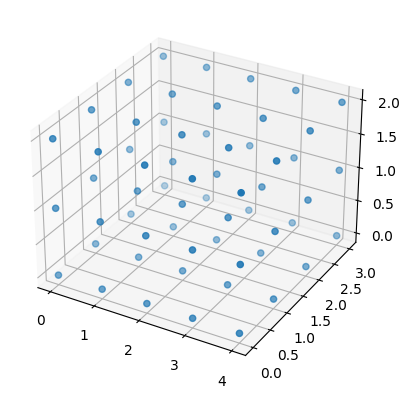

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# r is of shape [5, 1, 1]
r = torch.randn(5, 1, 1)

# r_sampling_ii is a scalar
r_sampling_ii = torch.tensor(0.5)

# mask will have shape [5, 1, 1]
mask = r < r_sampling_ii

# commonfactor is of shape [5, 4, 3]
commonfactor = torch.randn(5, 4, 3)


# mask_broad will be broadcasted to the shape of commonfactor [5, 4, 3]
mask_broad = mask * commonfactor


# Convert the tensor to a NumPy array
mask_broad_np = mask_broad.numpy()

# Get the indices where mask is True
x, y, z = np.where(mask_broad_np)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(x, y, z)
plt.show()

In [3]:
x

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [4]:
y

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3,
       3, 3, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 0, 0, 0, 1, 1, 1, 2, 2,
       2, 3, 3, 3, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3])

In [5]:
z

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1,
       2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2])

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the tensor
mask = torch.load("cmake-build-debug/testCPPLibrary/mask_double.pt")

# Convert the tensor to a NumPy array
mask_np = mask.numpy()

# Get the indices where mask is True
x, y, z = np.where(mask_np)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(x, y, z)
plt.show()


AttributeError: 'RecursiveScriptModule' object has no attribute 'numpy'